In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np


database_type = 'B'
out = 'data/csv/out_{}.csv'.format(database_type)

# Cesta k nasim datum
csv_data = out

# Nacteni dat
df = pd.read_csv(csv_data, delimiter=',')
# Odstraneni zbytecneho sloupce
df = df.drop(['Unnamed: 0'], axis = 1)

for column in df.columns:
    if df[column].dtype != 'int64':   
        # Hodnoty spojene v jeden string zpatky rozdelime do listu, aby se nam s nim lepe pracovalo
        df[column] = df[column].apply(lambda x: x.split(';') if isinstance(x, str)  else [])


C:\Users\Panuskova\AppData\Local\Temp\ipykernel_20420\1786722637.py:14: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_data, delimiter=',')


#### Selekce zaznamu pouze o Kuderovi

In [2]:
ind_Kundera = [True if any([True if author == 'Kundera, Milan' else False for author in author_list]) else False for author_list in df['figures']]
df_Kundera = df[ind_Kundera].copy(deep=True)


In [3]:
import re
from collections import Counter

# Funkce na "zplosteni" listu -> ze sloupce DataFramu vytvori jeden list se vsemi elementy 
def flatten_list(strings):
    flattened_list = []
    for item in strings:
        if isinstance(item, str):  # Pokud je element string, pridame ho do seznamu
            flattened_list.append(item)
        else:  # Rekurzivne zavola sebe
            flattened_list.extend(flatten_list(item))
    return flattened_list


In [4]:
all_genre = flatten_list(df_Kundera.genre)
counted_genre = Counter(all_genre)

ten_most_common_genre = [item[0] for item in counted_genre.most_common(10)]

# Count records per genre
genre_counts = {}

# Count total articles per year
total_counts = {}

# Iterate over each row in the DataFrame
for _, row in df_Kundera.iterrows():
    for year in row['year']: 
        genre_list = row['genre']
        year = int(year)
        # Increment the total count for the current year
        total_counts[year] = total_counts.get(year, 0) + 1
    
        # Iterate over each genre in the genres list for the current row
        for genre in genre_list:
            # Increment the count for the current genre and year
            genre_year = (genre, year)
            genre_counts[genre_year] = genre_counts.get(genre_year, 0) + 1

# Extract unique genres and years
genres = list(set([topic for topic, _ in genre_counts.keys()]))
years = list(set([year for _, year in genre_counts.keys()]))

# Sort the genres and years in ascending order
genres.sort()
years.sort()

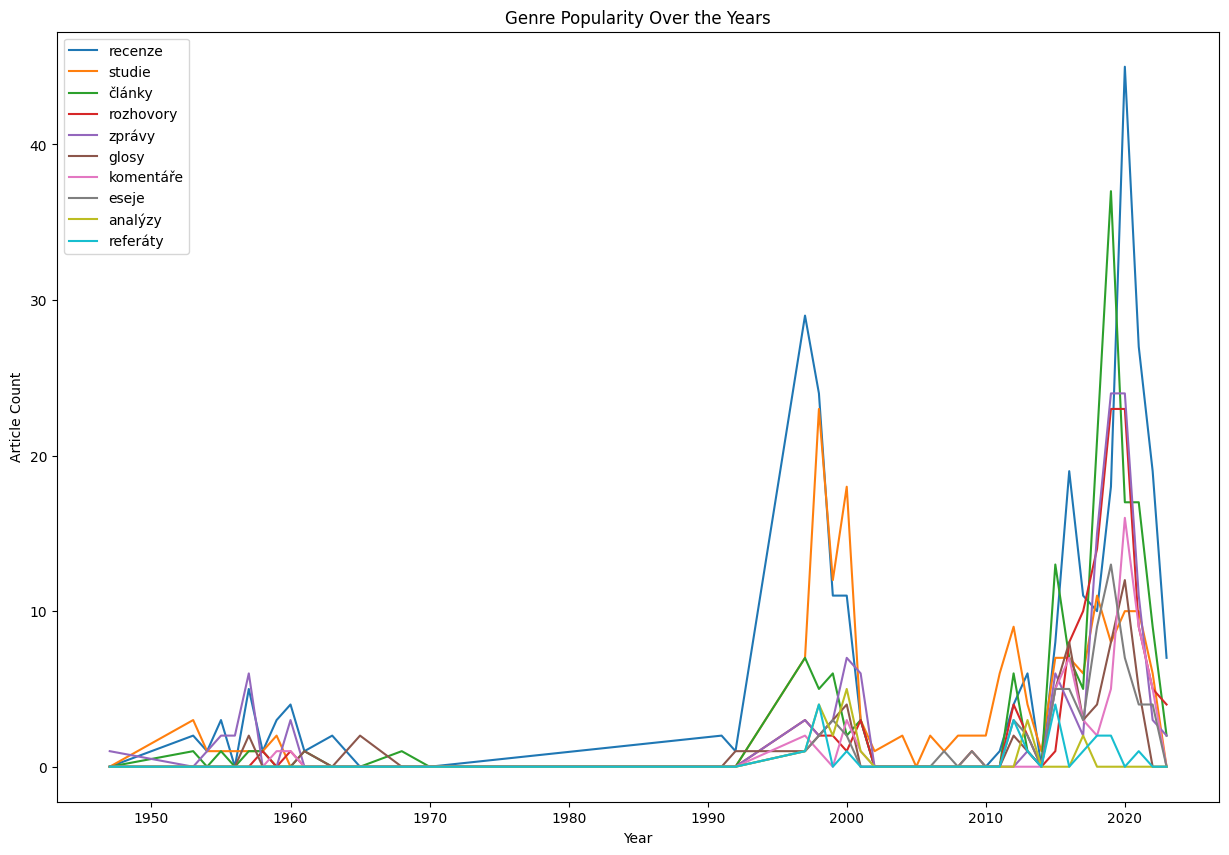

In [5]:
import matplotlib.pyplot as plt

# Create a line chart
plt1 = plt.figure(figsize=(15, 10))  # Set the figure size (optional)

# Plot the lines for each topic

for figure in ten_most_common_genre:
    counts = [genre_counts.get((figure, year), 0) for year in years]
    plt1 = plt.plot(years, counts, label=figure)

# Add labels and title
plt1 = plt.xlabel('Year')
plt1 = plt.ylabel('Article Count')
plt1 = plt.title('Genre Popularity Over the Years')

# Add a legend
plt1 = plt.legend()  

# Display the chart
plt.show()


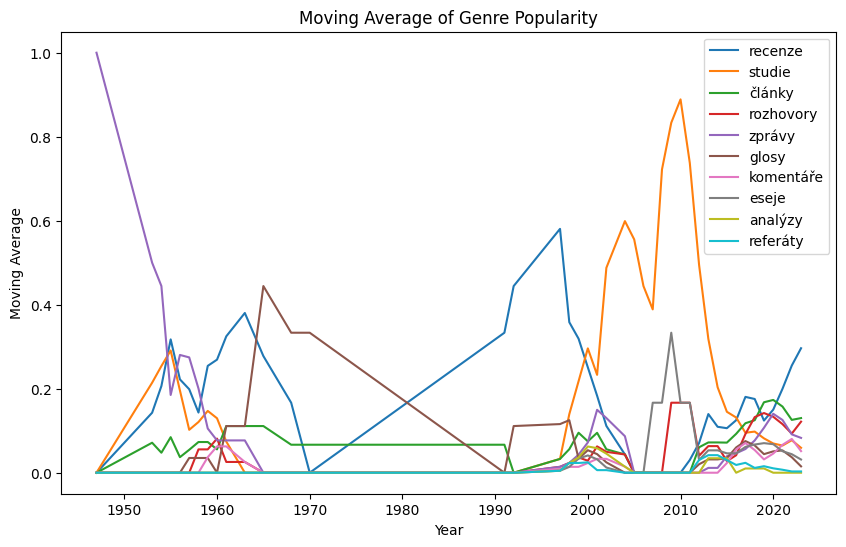

In [6]:
# Create a line chart
plt.figure(figsize=(10, 6))  # Set the figure size (optional)

proportions = {}
# Plot the lines for each topic
for genre in ten_most_common_genre:
    proportions[genre] = [genre_counts.get((genre, year), 0) / total_counts[year] for year in years]

# Calculate moving average
window_size = 3  # Define the window size for the moving average
moving_averages = {}
for topic, values in proportions.items():
    moving_averages[topic] = pd.Series(values).rolling(window=window_size, min_periods=1).mean()


for genre in ten_most_common_genre:    
    plt.plot(years, moving_averages[genre], label=genre)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Moving Average')
plt.title('Moving Average of Genre Popularity')

# Add a legend
plt.legend()  

# Display the chart
plt.show()

In [7]:
ind_Kundera = [True if any([True if author == 'Kundera, Milan' else False for author in author_list]) else False for author_list in df['figures']]
df_Kundera = df[ind_Kundera].copy(deep=True)


years_range = range(2010, 2023) 
df_Kundera['year'] = df_Kundera['year'].apply(lambda x: int(x[0]) if isinstance(x,list) and len(x)>0 else x )
ind_years = [True if (year in years_range) else False for year in df_Kundera['year']]
df_Kundera = df_Kundera[ind_years]

### Lemmatization

In [8]:
import spacy_udpipe
from collections import Counter

spacy_udpipe.download("cs") # stahnout cesky model

nlp = spacy_udpipe.load("cs")
lemmas = []
stop = ['Milan', 'Kundera', 'spisovatel', 'román']
column = 'title'
for _, row in df_Kundera.iterrows():
    for title in row[column]:
        if title.rfind('/') != '-1':
            title = title[:title.rfind(' /')]
        elif title.rfind(':') != '-1':
            title = title[:title.rfind(' :')]
        doc = nlp(title)

        # Extract lemmas for non-stopword tokens
        lemmas.append([token.lemma_ for token in doc if not(token.lemma_ in stop) and token.pos_ == 'ADJ'])
    

### Keyword extraction

In [ ]:
import yake

lemmas_string = sum(lemmas, [])
lemmas_string = " ".join(lemmas_string) 

kw_extractor = yake.KeywordExtractor()
language = "cs"
max_ngram_size = 2
deduplication_threshold = 0.9
numOfKeywords = 20
custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_threshold, top=numOfKeywords, features=None)


keywords = custom_kw_extractor.extract_keywords(lemmas_string)
for kw in keywords:
    print(kw)

('český český', 1.4723449630592049e-05)
('připojený bibliografický', 1.8844272008357347e-05)
('Kunderův Kunderův', 2.3576200778905257e-05)
('český literární', 4.174700690323288e-05)
('český Kunderův', 4.471100928620771e-05)
('Kunderův český', 4.471100928620771e-05)
('český připojený', 6.850653328010983e-05)
('český', 8.49320642939059e-05)
('Kunderův připojený', 8.667701249375637e-05)
('český uvedený', 9.42550722907676e-05)
('připojený biografický', 0.00010445122346132775)
('moravský zemský', 0.0001136788865489899)
('český zmíněný', 0.00011372944383458414)
('bibliografický připojený', 0.00012248776805432273)
('připojený český', 0.0001233117599041977)
('bibliografický český', 0.00012635846274088145)
('Jmenný český', 0.00012825119722243786)
('připojený Kunderův', 0.00013001551874063455)
('věnovaný český', 0.00013076953438460518)
('zmíněný český', 0.00013268435114034815)


In [ ]:
from gensim import corpora, models

preprocessed_headlines = lemmas

dictionary = corpora.Dictionary(preprocessed_headlines)

# Create a document-term matrix
doc_term_matrix = [dictionary.doc2bow(headline) for headline in preprocessed_headlines]

# Instantiate and train the LDA model
num_topics = 4  # Adjust the number of desired topics
lda_model = models.LdaModel(doc_term_matrix, num_topics=num_topics, id2word=dictionary, passes=10)

# Print the topics and their representative words
for topic_num, topic_words in lda_model.print_topics():
    print(f"Topic #{topic_num + 1}: {topic_words}")

Topic #1: 0.040*"rok" + 0.027*"literatura" + 0.026*"překlad" + 0.025*"dílo" + 0.016*"otázka" + 0.009*"čtenář" + 0.009*"žert" + 0.009*"film" + 0.007*"bůh" + 0.007*"dějiny"
Topic #2: 0.021*"jazyk" + 0.021*"knihovna" + 0.016*"myšlení" + 0.015*"láska" + 0.013*"archiv" + 0.012*"četba" + 0.010*"pravda" + 0.008*"úvaha" + 0.008*"domov" + 0.008*"moc"
Topic #3: 0.077*"kniha" + 0.018*"svět" + 0.015*"rok" + 0.011*"člověk" + 0.009*"básník" + 0.009*"kýč" + 0.008*"mýtus" + 0.008*"autor" + 0.007*"Ptákovina" + 0.007*"paradox"
Topic #4: 0.031*"život" + 0.023*"kultura" + 0.019*"cena" + 0.018*"občanství" + 0.018*"bezvýznamnost" + 0.015*"autor" + 0.012*"doba" + 0.011*"lehkost" + 0.011*"literatura" + 0.009*"návrat"


In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Convert the Gensim LDA model to pyLDAvis format
vis_data = gensimvis.prepare(lda_model, doc_term_matrix, dictionary)

# Visualize the LDA model
pyLDAvis.display(vis_data)

pyLDAvis.save_html(vis_data, "plots/Kundera/title/Kundera_noun_{}_{}.html".format(years_range.start, years_range.stop ))
